In [71]:
import keras
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import os,re, glob
import logging
import pandas as pd
import re,pyensembl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.decomposition
import itertools
import tensorflow as tf

%matplotlib inline
sns.set_style('whitegrid')

session_conf = tf.ConfigProto(
      intra_op_parallelism_threads=20,
      inter_op_parallelism_threads=20)
sess = tf.Session(config=session_conf)

from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM, Dense, Masking, Dropout, Conv1D, Activation
from keras.layers.wrappers import Bidirectional, TimeDistributed
K.set_session(sess)


chr_bins = [np.ones((int(np.ceil(seq_dict[k]/ws))-1)) for k in chromosomes]
mask = pad_sequences(chr_bins, value=0, padding='post', dtype='float').reshape(-1) == 1

ws = 5e6

In [2]:
cd /srv/shared/vanloo/rna2cn/SRP052901

/srv/shared/vanloo/rna2cn/SRP052901


# Pre-processing

### Load the metadata table

In [3]:
sample_table = pd.read_csv("/srv/shared/vanloo/rna2cn/SRP052901/sample_table.csv")
run_table = pd.read_table("/srv/shared/vanloo/rna2cn/SRP052901/run_table.tsv")

sample_table['Name'] = sample_table['Experiment Title'].apply(lambda x : re.match('\S+: (\S+);.*', x).groups()[0])
sample_table['isBulk'] = sample_table['Experiment Title'].str.contains('bulk')
sample_table = sample_table.merge(run_table, left_on='Experiment Accession', right_on='Experiment_s')
sample_table.set_index('Run_s', inplace=True)

cols = sample_table.columns
cols = cols.map(lambda x: x.replace(' ', '_') if isinstance(x, str) else x)
sample_table.columns = cols

sample_table.drop(['ReleaseDate_s', 'Platform_s', 'LibraryLayout_s', 'Consent_s', 'MBytes_l', 
                   'Instrument', 'Submitter', 'Study_Accession', 'Study_Title', 'Total_Spots', 'Total_RUNs',
                   'Total_Spots','Total_Bases','BioSample_s','AvgSpotLen_l', 'BioProject_s', 'Center_Name_s',
                  'Sample_Title', 'Library_Name', 'Organism_s', 'InsertSize_l', 'passage_s','SRA_Study_s',
                  'MBases_l', 'SRA_Sample_s','Instrument_s', 'LoadDate_s'], axis=1, inplace=True)
sample_table = sample_table.append(pd.Series({ 'Name':'bulk_liver_RNA', 
                                              'Library_Source':"TRANSCRIPTOMIC", 
                                              'isBulk':True, 
                                              'Organism_Name':'Homo sapiens', 
                                              'tissue_s':'adult liver', 
                                              'source_name_s':"human adult liver tissue"}, name='ERR030887'))
sample_table.head()

,Experiment_Accession,Experiment_Title,Organism_Name,Sample_Accession,"Total_Size,_Mb",Library_Strategy,Library_Source,Library_Selection,Name,isBulk,Assay_Type_s,Experiment_s,LibrarySelection_s,LibrarySource_s,Sample_Name_s,source_name_s,tissue_s,gender_s
Run_s,,,,,,,,,,,,,,,,,,
SRR3102618,SRX1531594,GSM2039773: bulk_HepG2_gDNA; Homo sapiens; Bis...,Homo sapiens,SRS1248904,546.42,Bisulfite-Seq,GENOMIC,Reduced Representation,bulk_HepG2_gDNA,True,Bisulfite-Seq,SRX1531594,Reduced Representation,GENOMIC,GSM2039773,HepG2 cell line,hepatocellular carcinoma,male
SRR3102617,SRX1531593,GSM2039772: bulk_HepG2_RRBS; Homo sapiens; Bis...,Homo sapiens,SRS1248905,2706.11,Bisulfite-Seq,GENOMIC,Reduced Representation,bulk_HepG2_RRBS,True,Bisulfite-Seq,SRX1531593,Reduced Representation,GENOMIC,GSM2039772,HepG2 cell line,hepatocellular carcinoma,male
SRR3102616,SRX1531592,GSM2039771: bulk_HepG2_RNA; Homo sapiens; RNA-Seq,Homo sapiens,SRS1248906,1614.42,RNA-Seq,TRANSCRIPTOMIC,cDNA,bulk_HepG2_RNA,True,RNA-Seq,SRX1531592,cDNA,TRANSCRIPTOMIC,GSM2039771,HepG2 cell line,hepatocellular carcinoma,male
SRR3102615,SRX1531591,GSM2039770: scRNA-seq_HepG2_2; Homo sapiens; R...,Homo sapiens,SRS1248907,724.66,RNA-Seq,TRANSCRIPTOMIC,cDNA,scRNA-seq_HepG2_2,False,RNA-Seq,SRX1531591,cDNA,TRANSCRIPTOMIC,GSM2039770,HepG2 cell line,hepatocellular carcinoma,male
SRR3102614,SRX1531590,GSM2039769: scRNA-seq_HepG2_1; Homo sapiens; R...,Homo sapiens,SRS1248908,703.82,RNA-Seq,TRANSCRIPTOMIC,cDNA,scRNA-seq_HepG2_1,False,RNA-Seq,SRX1531590,cDNA,TRANSCRIPTOMIC,GSM2039769,HepG2 cell line,hepatocellular carcinoma,male


### Load the referece fasta dictionary

In [4]:
chromosomes = list(map(str, range(1,23)))# + ['X']
seq_dict = {}
with open('/srv/shared/vanloo/rna2cn/references/Homo_sapiens.GRCh38/Homo_sapiens.GRCh38.dna_sm.primary_assembly.dict', 'r') as f:
    for line in f:
        if line[:3] == '@HD':
            continue
        _,sn,ln,*_ = line.split("\t")
        if sn[3] in 'MKGYX':
            continue
        seq_dict[sn[3:]] = int(ln[3:])


### Load the TPM matrix

In [5]:
liver_tpm = pd.read_csv("./RNA/kallisto_gene_tpm.csv", index_col=0)
liver_tpm.drop([x for x in liver_tpm.columns if  'ESC' in x or 'Hep' in x], axis=1, inplace=True)
liver_tpm.columns = [x.rsplit('_', 1)[0] for x in liver_tpm.columns]
liver_tpm.columns = pd.io.parsers.ParserBase({'names':liver_tpm.columns})._maybe_dedup_names(liver_tpm.columns)

samples = ['Ca_{0:02d}'.format(x) for x in range(1,27)]
bulks = ['cancer_bulk', 'cancer_bulk.1', 'bulk_liver']

### Extract gene locations from ensembl

In [6]:
ensembl = pyensembl.ensembl_grch38
genes = [ensembl.gene_by_id(x) for x in liver_tpm.index]

liver_tpm['chr'] = [x.contig if x.contig[0] in 'GKMXY' else int(x.contig) for x in genes]
liver_tpm['start'] = [x.start for x in genes]
liver_tpm['end'] = [x.end for x in genes]

liver_tpm.drop( liver_tpm[ liver_tpm['chr'].apply(lambda x:str(x)[0] in 'GKMYX') ].index, inplace=True)

In [7]:
liver_tpm_sort = liver_tpm.sort_values(['chr', 'start'])
tpm = liver_tpm_sort[liver_tpm_sort.columns[:-3]].as_matrix()
positions = liver_tpm_sort[liver_tpm_sort.columns[-3:]].as_matrix()

### Fine binning at 100kb

In [8]:
def fine_bin(data, ws, overlap_reduce,seq_dict=seq_dict):
    '''Takes an matrix input with four columns:

      chromosome, start, end, value
     
     for a list of region and duplicates the value 
     eg TPM or CN into ws sized bins accross each chromosome
     '''
    chr_lefts = {k: np.arange(0, v, ws) for k, v in seq_dict.items()}
    chr_bins = {k: np.zeros((int(np.ceil(v/ws)))) for k, v in seq_dict.items()}
    chr_bins_count = {k: np.zeros((int(np.ceil(v/ws)))) for k, v in seq_dict.items()}
    chromosomes = list(map(str, range(1,23)))# + ['X']

    for line in data:
        chr, s, e, x = line
        chr = str(int(chr))
        s_i, e_i = np.digitize([s,e], chr_lefts[chr])
        chr_bins[chr][s_i:e_i+1] = overlap_reduce(chr_bins[chr][s_i:e_i+1], chr_bins_count[chr][s_i:e_i+1], x)
        chr_bins_count[chr][s_i:e_i+1] += 1


    return [chr_bins[k][1:] for k in chromosomes]

In [9]:
# The data is log2(TPM+1) so in overlapping regions exp and sum, subtract 1 so the total pseudocounts in any bin is 1
liver_tpm_binned = {k: fine_bin(liver_tpm_sort[['chr', 'start', 'end', k]].as_matrix(),
                               ws,
                               lambda x,n,y: np.log2(1 + (n*(2**x-1) + 2**y-1)/(n+1) )) for k in samples + bulks}                                            

### Load the CNV BED files

In [10]:
cn_beds = glob.glob("/srv/shared/vanloo/rna2cn/SRP052901/RRBS/*/bismark/*.bed")
name = lambda k: sample_table.loc[os.path.basename(k).split('_')[0], 'Name'].rsplit('_', 1)[0]
liver_cn = {name(k): fine_bin(pd.read_table(k, header=None).as_matrix(), ws, lambda x,n,y: y) 
            for k in cn_beds}

# Temporary hack: at the centromeres the CN spikes so replace this with -1
for k in liver_cn.keys():
    for i,_ in enumerate(liver_cn[k]):
        liver_cn[k][i][liver_cn[k][i] > 5] = -1

### Load centromere masks

In [11]:
centromere_bed = pd.read_table("/srv/shared/vanloo/rna2cn/references/centromeres.bed", header=None).as_matrix()
X_centromere = np.array([pad_sequences(fine_bin(centromere_bed, ws, lambda x,n,y: y),value=-1, padding='post')])
X_centromere = np.tile(X_centromere, (1,26,1)).swapaxes(1,2).swapaxes(0,2)

### Create the sequence matrices

In [78]:
Y = np.concatenate([pad_sequences(liver_cn[k], value=-1, padding='post', dtype='float') for k in samples], axis=0)
Y_= Y.reshape((*Y.shape, -1))
Y = keras.utils.to_categorical(Y, 7).reshape((*Y.shape, 7))[:,:,:-1]

X_sc = np.concatenate([pad_sequences(liver_tpm_binned[k], value=-1, padding='post', dtype='float') for k in samples], axis=0)
X_sc = X_sc.reshape((*X_sc.shape, -1))

X_bulk = np.array([pad_sequences(liver_tpm_binned[k], value=-1, padding='post', dtype='float') for k in bulks])
X_bulk = np.tile(X_bulk, (1,26,1)).swapaxes(1,2).swapaxes(0,2)

#X = np.concatenate((X_sc, X_bulk, X_sc-X_bulk[:,:,2:3], X_centromere), axis=2)
X = np.concatenate((X_sc, X_bulk, X_centromere), axis=2)

### Train-Test Split

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.25)

# Define the model

In [80]:
model = Sequential()
model.add(Masking(mask_value=-1, input_shape=X.shape[1:]))

#model.add(Conv1D(32,10, padding='same', input_shape=X.shape[1:]))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(64, return_sequences=True)))
#model.add(Attention())
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.2))
#model.add(Bidirectional(LSTM(64, return_sequences=True)))
#model.add(Dropout(0.2))

model.add(TimeDistributed(Dense(6, activation='softmax')))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'mse'])

In [82]:
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    batch_size=5, epochs=30)

Train on 429 samples, validate on 143 samples
Epoch 1/30
429/429 [==============================] - 10s - loss: 1.0748 - acc: 0.5786 - mean_squared_error: 0.0964 - val_loss: 1.0448 - val_acc: 0.5748 - val_mean_squared_error: 0.0953
Epoch 2/30
429/429 [==============================] - 9s - loss: 0.9937 - acc: 0.5900 - mean_squared_error: 0.0910 - val_loss: 0.9279 - val_acc: 0.6168 - val_mean_squared_error: 0.0856
Epoch 3/30
429/429 [==============================] - 9s - loss: 0.9177 - acc: 0.6272 - mean_squared_error: 0.0852 - val_loss: 0.8928 - val_acc: 0.6222 - val_mean_squared_error: 0.0829
Epoch 4/30
429/429 [==============================] - 9s - loss: 0.8683 - acc: 0.6477 - mean_squared_error: 0.0810 - val_loss: 0.8728 - val_acc: 0.6207 - val_mean_squared_error: 0.0819
Epoch 5/30
429/429 [==============================] - 9s - loss: 0.8080 - acc: 0.6828 - mean_squared_error: 0.0750 - val_loss: 0.8273 - val_acc: 0.6723 - val_mean_squared_error: 0.0779
Epoch 6/30
429/429 [========

/home/dbunting/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


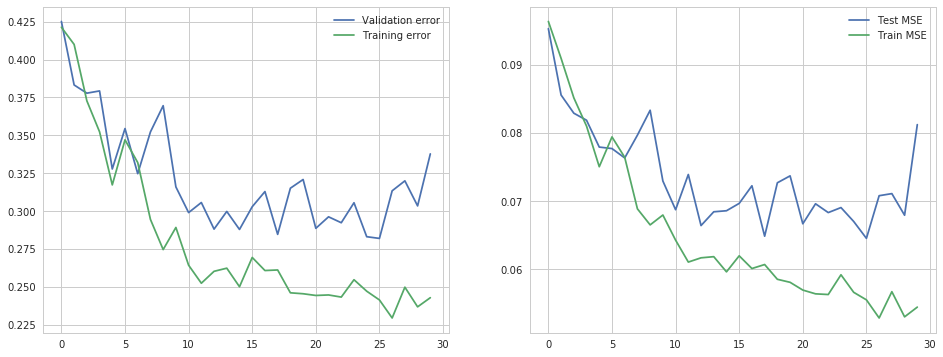

In [103]:
plt.figure(figsize=(16,6))
plt.subplot(121).plot(1 - np.array(history.history['val_acc']), label='Validation error')
plt.subplot(121).plot(1 - np.array(history.history['acc']), label='Training error')
plt.legend()
plt.subplot(122).plot(np.array(history.history['val_mean_squared_error']), label='Test MSE')
plt.subplot(122).plot(np.array(history.history['mean_squared_error']), label='Train MSE')
plt.legend()

In [85]:
pred = model.predict(X)

/home/dbunting/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


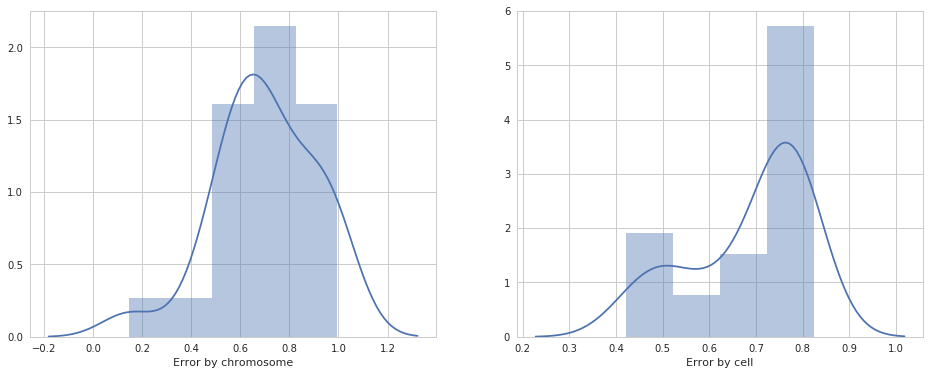

In [87]:
cell_metrics = np.array([model.evaluate(X[22*i:22*(i+1)], Y[22*i:22*(i+1)], verbose=0) for i in range(len(samples))])
chromosome_metrics = np.array([model.evaluate(X[i::22], Y[i::22], verbose=0) for i in range(22)])
metrics = np.array([model.evaluate(X[i:i+1], Y[i:i+1], verbose=0) for i in range(X.shape[0])])
plt.figure(figsize=(16,6))
sns.distplot(chromosome_metrics[:,1], ax=plt.subplot(121))
plt.subplot(121).set_xlabel('Error by chromosome')
sns.distplot(cell_metrics[:,1], ax=plt.subplot(122))
plt.subplot(122).set_xlabel('Error by cell')

/home/dbunting/miniconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/dbunting/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


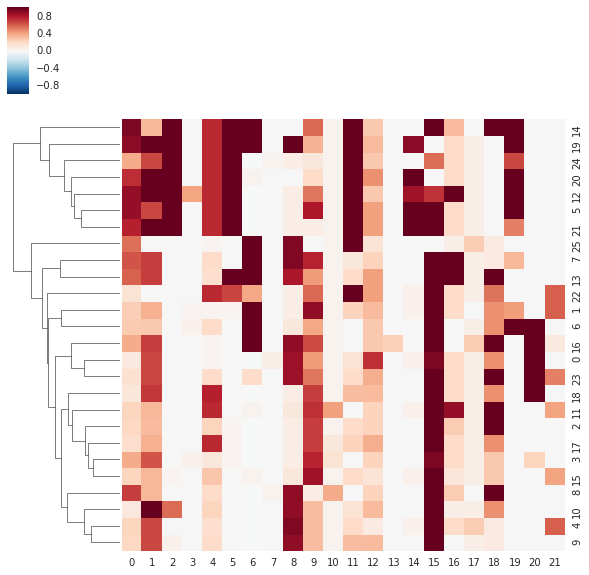

In [88]:
sns.clustermap(1-metrics[:,1].reshape((-1,22)), col_cluster=False)

In [90]:
def plot_genome(data, ax=None, pad=float('nan')):
    if np.isnan(pad):
        comp = np.isnan
    else:
        comp = lambda x:x==pad
        
    if ax is None:
        plt.figure(figsize=(24,2))
        ax = plt.gca()
        
    data = np.ravel(data, order='C')
    collapsed, boundaries = [], []
    
    for i,d in enumerate(data):
        if comp(d):
            if ~comp(data[i-1]):
                boundaries.append(len(collapsed))
                collapsed.append(d)
        else:
            collapsed.append(d)
    ax.plot(range(len(collapsed)), collapsed, '.', color='black')
    ax.vlines(boundaries, 0,6, color='gray')
    ax.set_ylim((0,5))
    

/home/dbunting/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


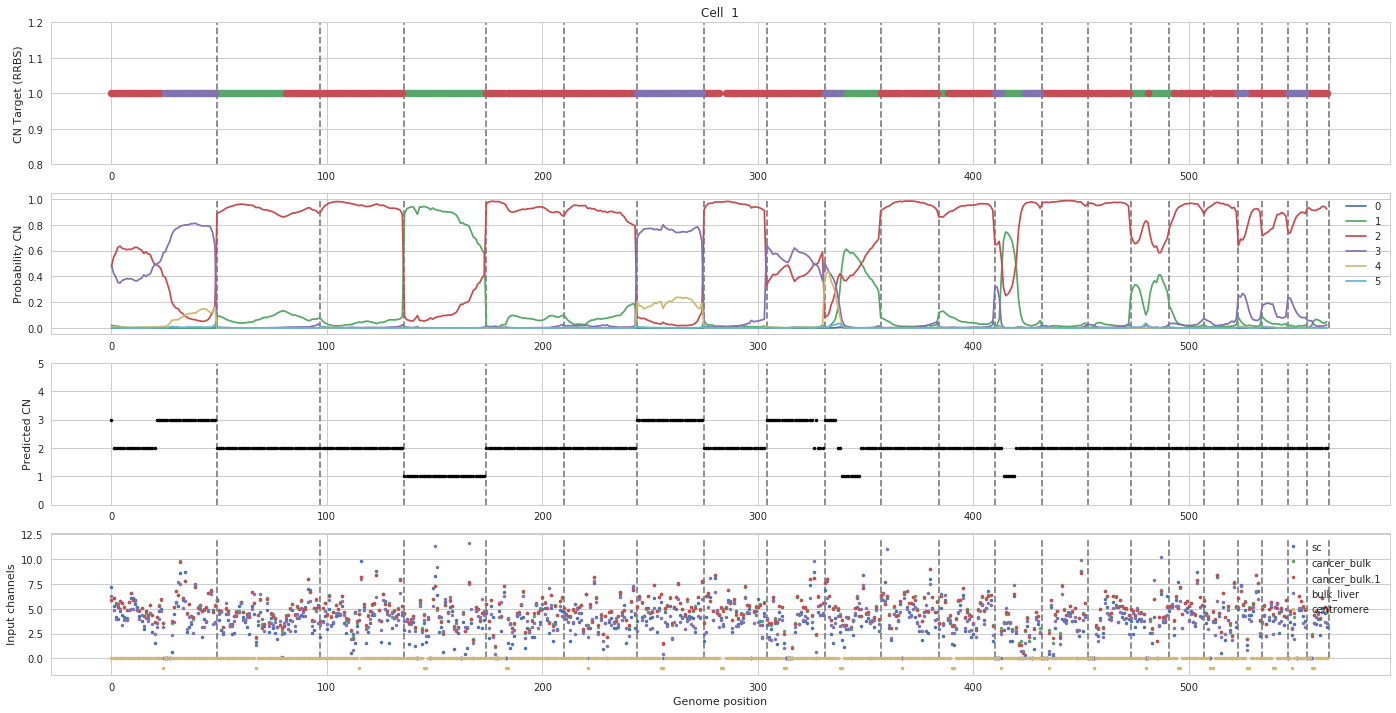

In [92]:
plt.figure(figsize=(24, 12))
i=0

plt.subplot(411).plot(Y[i*22:(i+1)*22].reshape((-1,6))[mask],'.', ms=15)
plt.subplot(411).set_ylim((0.8, 1.2))
plt.subplot(411).set_ylabel("CN Target (RRBS)")
plt.vlines(np.cumsum(list(map(len, chr_bins))), 0.8,1.2,linestyle='dashed', color='gray')
plt.title('Cell {0:2d}'.format(i+1))

for j in range(6):
    plt.subplot(412).plot(pred[i*22:(i+1)*22,:,j].reshape((-1))[mask], label=str(j))
plt.subplot(412).set_ylabel("Probability CN")
plt.subplot(412).vlines(np.cumsum(list(map(len, chr_bins))), 0.,1.,linestyle='dashed', color='gray')
plt.subplot(412).legend()

plt.subplot(413).plot(pred[i*22:(i+1)*22].argmax(axis=-1).reshape((-1))[mask], '.', color='black')
plt.subplot(413).set_ylabel("Predicted CN")
plt.subplot(413).vlines(np.cumsum(list(map(len, chr_bins))), 0,5,linestyle='dashed', color='gray')

plt.subplot(413).set_ylim((0,5))

for j,t in enumerate(["sc",'cancer_bulk', 'cancer_bulk.1', 'bulk_liver', 'centromere'] ):
    plt.subplot(414).plot(X[i*22:(i+1)*22,:,j].reshape((-1))[mask], '.', label=t)

plt.subplot(414).vlines(np.cumsum(list(map(len, chr_bins))), 0,12,linestyle='dashed', color='gray')
plt.subplot(414).legend()
plt.subplot(414).set_ylabel("Input channels")

plt.subplot(414).set_xlabel("Genome position")

/home/dbunting/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


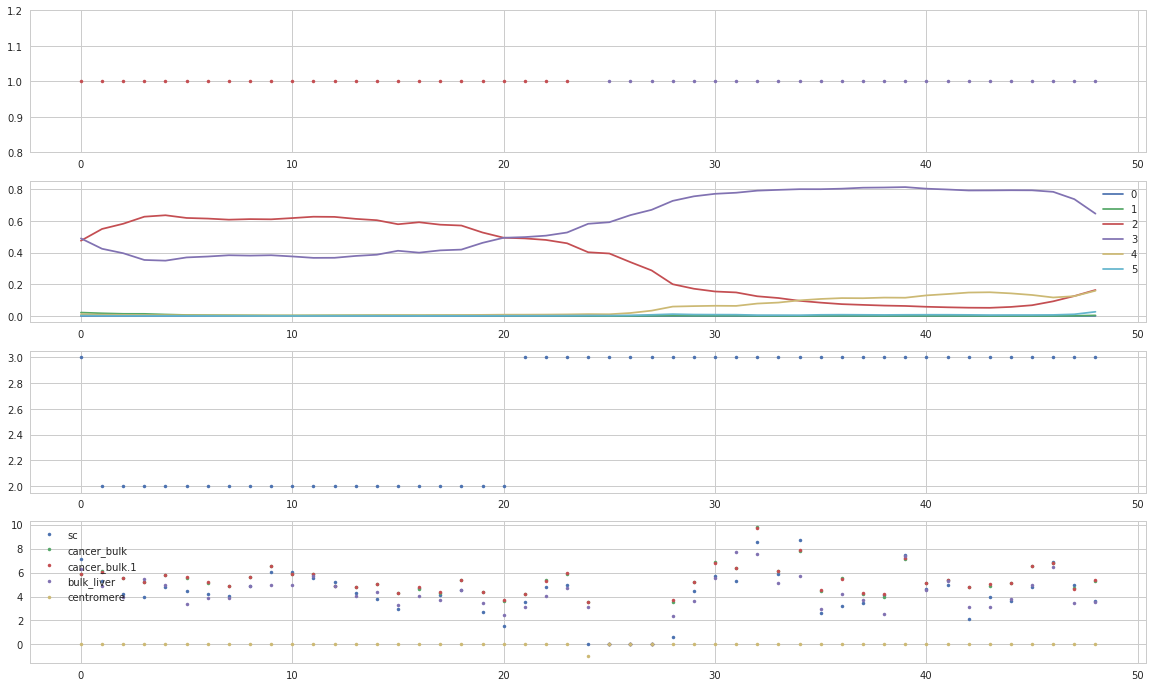

In [93]:
plt.figure(figsize=(20, 12))
i=0
plt.subplot(411).plot(Y[i].reshape((-1,6)),'.', linewidth=10)
plt.subplot(411).set_ylim((0.8, 1.2))

for j in range(pred.shape[2]):
    plt.subplot(412).plot(pred[i,:,j], label=str(j))
plt.subplot(412).legend()

plt.subplot(413).plot(pred.argmax(axis=-1)[i].reshape((-1)), '.')

for j,t in enumerate(["sc",'cancer_bulk', 'cancer_bulk.1', 'bulk_liver', 'centromere'] ):
    plt.subplot(414).plot(X[i,:,j].reshape((-1)), '.', label=t)
plt.subplot(414).legend(loc=2)

/home/dbunting/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


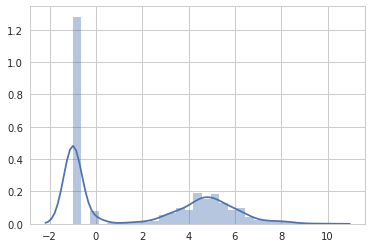

In [99]:
sns.distplot(X[:,:,1].reshape(-3))

In [100]:
history.history

{'acc': [0.57862071887457567,
  0.58996499244705503,
  0.62720488605799374,
  0.64770652444073651,
  0.68276689331848306,
  0.65300862584914365,
  0.66800680645418054,
  0.70559263548928819,
  0.72549628551467593,
  0.71088875965638598,
  0.73583120823184367,
  0.7477203754139391,
  0.73986011118321982,
  0.73778766539546992,
  0.75004799035323533,
  0.73069686690966285,
  0.7393376906434973,
  0.73897547050789525,
  0.75406186716817758,
  0.75467845332094563,
  0.75580859232893638,
  0.75547346660307235,
  0.75688356418153901,
  0.74541809745046084,
  0.75299156538812151,
  0.7587780621779826,
  0.77068185313042503,
  0.75034170953821744,
  0.76332946667026524,
  0.75727973583139185],
 'loss': [1.0748369265825322,
  0.99372736251715454,
  0.91772241706336855,
  0.86832716213517536,
  0.80797544212052319,
  0.84827382761837444,
  0.81268171455476668,
  0.73258255165078978,
  0.71831856237285896,
  0.7186790624837498,
  0.68435465924806527,
  0.64988037599967075,
  0.64164703994086292,
